Animations of vibrating strings, built from their Fourier components

In [5]:
import scipy
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
%matplotlib inline

# Set Up Animation Inline Display

In [6]:
# Citation: The code in this cell, to display animations inline, was from 
# http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/

from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=2, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

# Violin String

In [25]:
# Define constants
L = 100              # Length of string
v = 1.               # Wave velocity
WL = 2*L             # Wavelength of fundamental
f = v/WL             # Frequency of fundamental
T = 1/f              # Period
epsilon = 1e-3       # For numerical stability
w = 2 * np.pi * f    # Omega: angular velocity of fundamental

In [26]:
# Fourier coefficient
# (For mathematical derivation, see: http://mathworld.wolfram.com/FourierSeriesTriangleWave.html)
# n: mode number
# m: where the "kink" is along the string, as a fraction of string length
def b(n, m):
    ret = -2 * (-1)**n * m**2 / (n**2 * (m-1) * (np.pi)**2) * np.sin(n * (m-1) * np.pi / m )
    return ret

In [27]:
# Shape of nth harmonic for a given m
def harm(x, n, m):
    return b(n, m) * np.sin(n * np.pi * x / L)

In [28]:
# m as a function of t (The kink moves up and down the string)
def funcm(t):
    ret = 1/(t + epsilon) * T/4 * 2
    return ret

In [29]:
# Shape of sum of harmonics from ith to fth harmonic, for a given m
def sawn(x, m, ni, nf):
    ret = 0
    for n in range (ni,nf):
        ret = ret + harm(x, n, m)
    return ret

In [30]:
# Shape of sum of harmonics from ith to fth harmonic, as a function of time
# Need to consider 4 cases, depending on position of kink (left half, right half, pointing upwards or pointing downwards)

def waven(x, t, ni, nf):
    div = int(t/T)
    remt = float(t) - div*T
    func = 0
    if (remt >= 0 and remt < T/4):
        m = funcm(remt)
        func = sawn(x, m, ni, nf)
    elif (remt >= T/4 and remt < T/2):
        m = funcm(T/2 - remt)
        func = sawn(L - x, m, ni, nf)
    elif (remt >=T/2 and remt < 3*T/4):
        m = funcm(remt - T/2)
        func = sawn(L - x, m, ni, nf)
    else:
        m = funcm(T - remt)
        func = sawn(x, m, ni, nf)
    return func * np.sin(w * t)
        

In [31]:
# Define x axis
xx = np.arange(0,L+2)

In [11]:
# Animate modes of violin
# Runs for one period

step = 5       # Control how fine the animation is time-wise

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9,6.5))
fig.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.85, wspace=None, hspace=None) # Formatting
fig.suptitle('Modes of a bowed string', fontsize=14, fontweight='bold')
fig.text(0.97, 0.03, '$\copyright$ Tremblings and Warblings, 2017', fontsize=10, color='gray', ha='right', va='bottom')

# Axes
axlim = 1.4
axleeway = 2

dotlarr = np.array([])   # Left anchor of string
dotrarr = np.array([])   # Right anchor of string
linearr = np.array([])   # String
j = 0
for ax in axs.reshape(-1):
    ax.set_xlim([0,L+axleeway])
    ax.set_ylim([-axlim, axlim])
    ax.axis("off")

    dotl, = ax.plot([], [], 'ko')
    dotr, = ax.plot([], [], 'ko')
    line, = ax.plot([], [], lw=1, color='k')
    
    ax.set_title('Mode # ' + str(j+1), color='k')
    
    dotlarr = np.append(dotlarr, dotl)
    dotrarr = np.append(dotrarr, dotr)
    linearr = np.append(linearr, line)
    j = j + 1

lines = []
j = 0
for ax in axs.reshape(-1):
    lines.append(linearr[j])
    lines.append(dotlarr[j])
    lines.append(dotrarr[j])
    j = j + 1
def init():
    j = 0
    for ax in axs.reshape(-1):
        (linearr[j]).set_data([],[])
        (dotlarr[j]).set_data([],[])
        (dotrarr[j]).set_data([],[])
        j = j + 1
    return lines
def animate(time):
    j = 0
    for ax in axs.reshape(-1):
        (linearr[j]).set_data(xx,waven(xx-1, time*step, j+1, j+2))
        (dotlarr[j]).set_data(1,0)
        (dotrarr[j]).set_data(L+1,0)
        j = j + 1
    return lines

ann = animation.FuncAnimation(fig, animate, init_func=init, frames = int(T/step), interval = 100, blit=True)
display_animation(ann)
#ann.save('violin_fourier.mp4', writer = 'ffmpeg')
#ann.save('bowed_string_modes_only_r.gif', dpi = 93, writer = 'imagemagick')

In [16]:
#Adding successive modes of violin

step = 3                # Controls how fine the animation is (time-wise). Lower step = finer
frameT = float(T)/step  # Number of frames per period

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
fig.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.9, wspace=None, hspace=None)
fig.suptitle('Combining the modes of a bowed string', fontsize=14, fontweight='bold')
fig.text(0.97, 0.03, '$\copyright$ Tremblings and Warblings, 2017', fontsize=10, color='gray', ha='right', va='bottom')

axlim = 1.4
axleeway = 2

dotlarr = np.array([])
dotrarr = np.array([])
linearr = np.array([])
j = 0
for ax in axs.reshape(-1):
    ax.set_xlim([0,L+axleeway])
    ax.set_ylim([-axlim, axlim])
    ax.axis("off")
    #print("this")
    dotl, = ax.plot([], [], 'ko')
    dotr, = ax.plot([], [], 'ko')
    line, = ax.plot([], [], lw=1, color='r')

    if (j > 2):
        line, = ax.plot([], [], lw=1, color='k')
        ax.set_title('Mode # ' + str(j-2), color='k')
        
    dotlarr = np.append(dotlarr, dotl)
    dotrarr = np.append(dotrarr, dotr)
    linearr = np.append(linearr, line)
    j = j + 1

lines = []
j = 0
for ax in axs.reshape(-1):
    lines.append(linearr[j])
    lines.append(dotlarr[j])
    lines.append(dotrarr[j])
    j = j + 1
def init():
    j = 0
    for ax in axs.reshape(-1):
        (linearr[j]).set_data([],[])
        (dotlarr[j]).set_data([],[])
        (dotrarr[j]).set_data([],[])
        j = j + 1
    return lines
def animate(time):
    maxmode = int(time/frameT) + 1
    j = 0
    for ax in axs.reshape(-1):
        if (j == 1):
            ax.set_title('Sum of first ' + str(maxmode) + ' modes:', color='r')
            (linearr[j]).set_data(xx,waven(xx-1, time*step, 1, 1 + maxmode))
            if (maxmode > 6):
                (linearr[j]).set_data(xx,waven(xx-1, time*step, 1, 31))
                ax.set_title('Sum of first ' + str(30) + ' modes:', color='r')
        elif (j > 2):
            factor = 0
            if (maxmode > j-3):
                factor = 1
            (linearr[j]).set_data(xx,factor*waven(xx-1, time*step, j-2, j-1))
            
        if ((j != 2) and (j != 0)):
            (dotlarr[j]).set_data(1,0)
            (dotrarr[j]).set_data(L+1,0)
        j = j + 1
    return lines

#ann = animation.FuncAnimation(fig, animate, init_func=init, frames = int((1)*frameT), interval = 40, blit=True)
ann = animation.FuncAnimation(fig, animate, init_func=init, frames = int((6+1)*frameT), interval = 40, blit=True)
display_animation(ann)
#ann.save('bowed_string4b.mp4', writer = 'ffmpeg', dpi = 250)
#ann.save('bowed_string3.gif', dpi = 300, writer = 'imagemagick')

In [17]:
# Modes, plus sum of first 6 modes and firs 30 modes

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
fig.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97, wspace=None, hspace=None)

axlim = 1.4
axleeway = 2

dotlarr = np.array([])
dotrarr = np.array([])
linearr = np.array([])
j = 0
for ax in axs.reshape(-1):
    ax.set_xlim([0,L+axleeway])
    ax.set_ylim([-axlim, axlim])
    ax.axis("off")
    #print("this")
    dotl, = ax.plot([], [], 'ko')
    dotr, = ax.plot([], [], 'ko')
    line, = ax.plot([], [], lw=1, color='r')
    if (j == 0):
        ax.set_title('Sum of first 30 modes:', color='r')
    if (j == 1):
        ax.set_title('Sum of first 6 modes:', color='r')
    if (j > 2):
        line, = ax.plot([], [], lw=1, color='k')
        ax.set_title('Mode # ' + str(j-2), color='k')
    dotlarr = np.append(dotlarr, dotl)
    dotrarr = np.append(dotrarr, dotr)
    linearr = np.append(linearr, line)
    j = j + 1

lines = []
j = 0
for ax in axs.reshape(-1):
    lines.append(linearr[j])
    lines.append(dotlarr[j])
    lines.append(dotrarr[j])
    j = j + 1
def init():
    j = 0
    for ax in axs.reshape(-1):
        (linearr[j]).set_data([],[])
        (dotlarr[j]).set_data([],[])
        (dotrarr[j]).set_data([],[])
        j = j + 1
    return lines
def animate(time):
    j = 0
    for ax in axs.reshape(-1):
        if (j == 0):
            (linearr[j]).set_data(xx,waven(xx-1, time*7, 1, 31))
        elif (j == 1):
            (linearr[j]).set_data(xx,waven(xx-1, time*7, 1, 7))
        elif (j > 2):
            (linearr[j]).set_data(xx,waven(xx-1, time*7, j-2, j-1))
        if (j != 2):
            (dotlarr[j]).set_data(1,0)
            (dotrarr[j]).set_data(L+1,0)
        j = j + 1
    return lines

ann = animation.FuncAnimation(fig, animate, init_func=init, frames = int(T/7), interval = 200, blit=True)
display_animation(ann)
#ann.save('violin_fourier.mp4', writer = 'ffmpeg')
#.save('bowed_string2.gif', dpi = 300, writer = 'imagemagick')

In [32]:
# Sine waves of different phases

step = 5

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9,2))
fig.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.95, wspace=None, hspace=None)
fig.suptitle('Sine waves with different phases', fontsize=14, fontweight='bold')
#fig.text(0.97, 0.03, '$\copyright$ Tremblings and Warblings, 2017', fontsize=10, color='gray', ha='right', va='bottom')

axlim = 0.7
axleeway = 2

dotlarr = np.array([])
dotrarr = np.array([])
linearr = np.array([])
j = 0
for ax in axs.reshape(-1):
    ax.set_xlim([0,L+axleeway])
    ax.set_ylim([-axlim, axlim])
    ax.axis("off")

    dotl, = ax.plot([], [], 'ko')
    dotr, = ax.plot([], [], 'ko')
    #line, = ax.plot([], [], lw=1, color='r')
    line, = ax.plot([], [], lw=1, color='k')

    dotlarr = np.append(dotlarr, dotl)
    dotrarr = np.append(dotrarr, dotr)
    linearr = np.append(linearr, line)
    j = j + 1

lines = []
j = 0
for ax in axs.reshape(-1):
    lines.append(linearr[j])
    lines.append(dotlarr[j])
    lines.append(dotrarr[j])
    j = j + 1
def init():
    j = 0
    for ax in axs.reshape(-1):
        (linearr[j]).set_data([],[])
        (dotlarr[j]).set_data([],[])
        (dotrarr[j]).set_data([],[])
        j = j + 1
    return lines
def animate(time):
    j = 0
    for ax in axs.reshape(-1):
        (linearr[j]).set_data(xx,waven(xx-1, time*step + 25*j, 2, 3))
        (dotlarr[j]).set_data(1,0)
        (dotrarr[j]).set_data(L+1,0)
        j = j + 1
    return lines

ann = animation.FuncAnimation(fig, animate, init_func=init, frames = int(T/step/2), interval = 150, blit=True)
display_animation(ann)
#ann.save('sine_phases_r.gif', dpi = 93, writer = 'imagemagick')

In [33]:
# Sine modes and sum of first 6 and first 30, with different layout

#fig = plt.figure(figsize=(9,6))
#ax0=fig.add_subplot(4,2,1)
#axarr = np.copy(ax0)

#for i in range(1,8):
#    ax = fig.add_subplot(4,2,i+1)
#    axarr = np.vstack((axarr, ax))

#print(axarr)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9,10))
fig.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97, wspace=None, hspace=None)

#ax1=fig.add_subplot(4,2,1)
#ax2=fig.add_subplot(4,2,2)
#ax3=fig.add_subplot(4,2,3)
#ax4=fig.add_subplot(4,2,4)
#ax5=fig.add_subplot(4,2,5)
#ax6=fig.add_subplot(4,2,6)
#ax7=fig.add_subplot(4,2,7)
#ax8=fig.add_subplot(4,2,8)

axlim = 1.4
axleeway = 2

#for i in range(0, axarr.shape[0]):
#    ax = axarr[0]
#for ax in axarr:
dotlarr = np.array([])
dotrarr = np.array([])
linearr = np.array([])
j = 0
for ax in axs.reshape(-1):
    ax.set_xlim([0,L+axleeway])
    ax.set_ylim([-axlim, axlim])
    ax.axis("off")
    #print("this")
    dotl, = ax.plot([], [], 'ko')
    dotr, = ax.plot([], [], 'ko')
    line, = ax.plot([], [], lw=1, color='r')
    if (j == 0):
        ax.set_title('Sum of first 30 sine waves:', color='r')
    if (j == 1):
        ax.set_title('Sum of first 6 sine waves:', color='r')
    if (j > 1):
        line, = ax.plot([], [], lw=1, color='k')
        ax.set_title('Sine wave # ' + str(j-1), color='k')
    dotlarr = np.append(dotlarr, dotl)
    dotrarr = np.append(dotrarr, dotr)
    linearr = np.append(linearr, line)
    j = j + 1

#ax.axis("off")
lines = []
j = 0
for ax in axs.reshape(-1):
    lines.append(linearr[j])
    lines.append(dotlarr[j])
    lines.append(dotrarr[j])
    j = j + 1
def init():
    j = 0
    for ax in axs.reshape(-1):
        (linearr[j]).set_data([],[])
        (dotlarr[j]).set_data([],[])
        (dotrarr[j]).set_data([],[])
        j = j + 1
    return lines
def animate(time):
    #xx = np.arange(0, WL/2)
    #line.set_data(xx,wave(xx, time*10))
    j = 0
    for ax in axs.reshape(-1):
        if (j == 0):
            (linearr[j]).set_data(xx,waven(xx-1, time*7, 1, 30))
        elif (j == 1):
            (linearr[j]).set_data(xx,waven(xx-1, time*7, 1, 7))
        elif (j > 1):
            (linearr[j]).set_data(xx,waven(xx-1, time*7, j-1, j))
        (dotlarr[j]).set_data(1,0)
        (dotrarr[j]).set_data(L+1,0)
        j = j + 1
    return lines

ann = animation.FuncAnimation(fig, animate, init_func=init, frames = int(T/7), interval = 200, blit=True)
display_animation(ann)
#ann.save('violin_fourier.mp4', writer = 'ffmpeg')
#ann.save('bowed_string_modes.gif', dpi = 300, writer = 'imagemagick')

# Guitar String

In [17]:
# Define constants
L = 100              # Length of string
#v = 1.               # Wave velocity
WL = 2*L             # Wavelength of fundamental
#f = v/WL             # Frequency of fundamental
#T = 1/f              # Period
#epsilon = 1e-3       # For numerical stability
#w = 2 * np.pi * f    # Omega: angular velocity of fundamental

# Define x axis
xx = np.arange(0,L+2)

In [8]:
# Amplitude of Fourier component
# For plucked string, m is fixed.  
# It indicates how far along the string the string was plucked (as a fraction of total string length)
# For derivation, see http://mathworld.wolfram.com/FourierSeriesTriangleWave.html

def guitamp(m, n):
    nn = float(n)
    mm = float(m)
    ampli = (-(2*(-1)**nn * mm**2)/(nn**2 * (mm-1))/(np.pi)**2) * np.sin(nn*(mm-1)*np.pi/mm)
    return ampli

In [9]:
# Shape of one mode as a function of its angular frequency w, and time t
def y(x, t, w, phi):
    return np.sin(2*np.pi*x/(WL/w)) * np.cos(w*t + phi)

In [10]:
# Try adding up first few modes, with phases flipped every 1/m modes

def yy(x):
    return y(x,1,0) + y(x,2,0) + y(x,3,0) + y(x,4,0) + y(x,6,-1*np.pi) + y(x,7,-1*np.pi)

In [11]:
# Find sum of modes n1 to n2-1

def yyy(x, t, n1, n2):
    m = 5
    ret = 0
    #A = np.array([1, 0.4, 0.18, 0.06, 0., 0.03])          # Amplitudes of first 6 modes given in Rossing
    A = np.zeros(50)                                       # Calculate amplitudes from first principles
    for i in range(1, 51):
        A[i-1] = np.abs(guitamp(m, i))
    #phase = np.array([0.5*np.pi, 0, -0.5*np.pi, -0])      # Manually trying different phases
    for i in range(n1,n2):
        #A = 1
        div = i/m                                          # These lines flip the phase every m modes
        remainder = np.mod(i,m)
        rempha = np.mod(div,2)
        phi = 0
        #print(rempha)
        if (remainder == 0):                               # Set amplitude to zero when n is a multiple of m
            Aa = 0                                         # Not necessary since we're already calculating from first principles
        elif (rempha == 0):
            phi = 0
        elif (rempha == 1):
            phi = -1*np.pi
            
        ret = ret + (A[i-1])*y(x, t, i, phi)               # Add modes
        #plt.plot(xx, A*y(xx, tt, i, phi))
        #plt.show()
    return ret

In [18]:
#Adding successive modes guitar

step = 0.1               # Step size is a different scale from violin anim, since I'm scaling differently here
#frameT = float(T)/step  #number of frames per period
frameT = 2*np.pi/step
m = 5

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
fig.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.9, wspace=None, hspace=None)
fig.suptitle('Combining the modes of a plucked string', fontsize=14, fontweight='bold')
fig.text(0.97, 0.03, '$\copyright$ Tremblings and Warblings, 2017', fontsize=10, color='gray', ha='right', va='bottom')

axlim = 1.4
axleeway = 2

dotlarr = np.array([])          # Left anchor point of string
dotrarr = np.array([])          # Right anchor point of string
linearr = np.array([])          # String
j = 0
for ax in axs.reshape(-1):
    ax.set_xlim([0,L+axleeway])
    ax.set_ylim([-axlim, axlim])
    ax.axis("off")

    dotl, = ax.plot([], [], 'ko')
    dotr, = ax.plot([], [], 'ko')
    line, = ax.plot([], [], lw=1, color='r')

    if (j > 0):
        line, = ax.plot([], [], lw=1, color='k')
        ax.set_title('Mode # ' + str(j), color='k')
    dotlarr = np.append(dotlarr, dotl)
    dotrarr = np.append(dotrarr, dotr)
    linearr = np.append(linearr, line)
    j = j + 1

lines = []
j = 0
for ax in axs.reshape(-1):
    lines.append(linearr[j])
    lines.append(dotlarr[j])
    lines.append(dotrarr[j])
    j = j + 1
    
def init():
    j = 0
    for ax in axs.reshape(-1):
        (linearr[j]).set_data([],[])
        (dotlarr[j]).set_data([],[])
        (dotrarr[j]).set_data([],[])
        j = j + 1
    return lines

def animate(time):
    maxmode = int(time/frameT) + 1
    j = 0
    for ax in axs.reshape(-1):
        if (j == 0):
            ax.set_title('Sum of first ' + str(maxmode) + ' modes:', color='r')
            #(linearr[j]).set_data(xx,guitadd(xx-1, time*step, m, 1, 1 + maxmode))
            (linearr[j]).set_data(xx,yyy(xx-1, time*step, 1, 1 + maxmode))
            if (maxmode > 8):
                (linearr[j]).set_data(xx,yyy(xx-1, time*step, 1, 51))
                ax.set_title('Sum of first ' + str(50) + ' modes:', color='r')

        elif (j > 0):
            factor = 0
            if (maxmode > j-1):
                factor = 1
            (linearr[j]).set_data(xx,factor*yyy(xx-1, time*step, j, j+1))

        (dotlarr[j]).set_data(1,0)
        (dotrarr[j]).set_data(L+1,0)
        j = j + 1
    return lines

#ann = animation.FuncAnimation(fig, animate, init_func=init, frames = int((1)*frameT), interval = 40, blit=True)
ann = animation.FuncAnimation(fig, animate, init_func=init, frames = int((10+1)*frameT), interval = 40, blit=True)
display_animation(ann)
#ann.save('plucked_stringb.mp4', writer = 'ffmpeg', dpi = 200)

In [19]:
# Animate sum of first 50 modes

fig = plt.figure()
ax = plt.axes(xlim = (0,WL/2), ylim = (-1.5, 1.5))
line, = ax.plot([], [], lw=1, color='r')
line2, = ax.plot([], [], lw=1, color='b')
line3, = ax.plot([], [], lw=1, color='k')
ax.axis("off")
lines = []
lines.append(line)
lines.append(line2)
lines.append(line3)

def init():
    line.set_data([],[])
    line2.set_data([],[])
    line3.set_data([],[])
    return lines

def animate(time):
    xx = np.arange(0, WL/2)
    line.set_data(xx,yyy(xx, time*0.1, 1, 51))
    return lines

ann = animation.FuncAnimation(fig, animate, init_func=init, frames = 64, interval = 300, blit=True)
display_animation(ann)
#ann.save('violin_fourier.mp4', writer = 'ffmpeg')

## Guitar Unused Functions

In [2]:
# Shape of nth harmonic, as a function of x and t

def guitsin(m, n, x, t):
    div = n/m
    remainder = np.mod(n,m)      # These few lines flip the phases every m modes
    rempha = np.mod(div,2)
    phi = 0    
    if (rempha == 1):
        phi = -1*np.pi

    ret = guitamp(m, n) * np.sin(n * np.pi * x/(2*L/n)) * np.cos(n * t + phi)
    return ret

In [3]:
# Add modes n1 to n2-1

def guitadd(x, t, m, n1, n2):
    ret = 0
    for i in range(n1, n2):
        ret = ret + guitsin(m, i, x, t)
    return ret

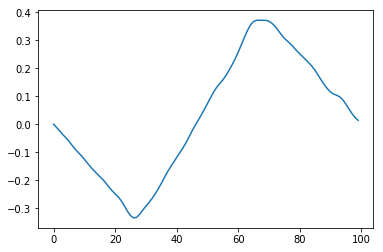

In [168]:
tt = 1.5
WL = 200
xx = np.arange(0,WL/2)
#plt.show()
plt.plot(xx, yyy(xx, tt))

# Violin String: Unused Functions

In [19]:
# Shape of sum of first 30 harmonics, for a given m
# This function is not used for the animation
def saw(x, m):
    ret = 0
    for n in range (1,30):
        ret = ret + harm(x, n, m)
    return ret

In [20]:
# Shape of sum of first 30 harmonics as a function of t
# Need to consider 4 cases, depending on position of kink (left half, right half, pointing upwards or pointing downwards)
def wave(x, t):
    div = int(t/T)
    #print(div)
    remt = float(t) - div*T
    func = 0
    #print remt
    if (remt >= 0 and remt < T/4):
        m = funcm(remt)
        func = saw(x, m)
    elif (remt >= T/4 and remt < T/2):
        m = funcm(T/2 - remt)
        func = saw(L - x, m)
    elif (remt >=T/2 and remt < 3*T/4):
        m = funcm(remt - T/2)
        func = saw(L - x, m)
    else:
        m = funcm(T - remt)
        func = saw(x, m)
    return func * np.sin(w * t)
        

In [21]:
#Sum of first 30 modes

fig = plt.figure(figsize = (8,4))
fig.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97, wspace=None, hspace=None)
ax = plt.axes(xlim = (0,L+2), ylim = (-1.1, 1.1))
line, = ax.plot([], [], lw=1, color='r')
dotl, = ax.plot([], [], 'ko')
dotr, = ax.plot([], [], 'ko')
ax.axis("off")
lines = []
lines.append(line)
lines.append(dotl)
lines.append(dotr)
def init():
    line.set_data([],[])
    dotl.set_data([],[])
    dotr.set_data([],[])
    return lines
def animate(time):
    line.set_data(xx,wave(xx-1, time*7))
    dotl.set_data(0.9,0)
    dotr.set_data(L+1,0)
    return lines

ann = animation.FuncAnimation(fig, animate, init_func=init, frames = int(T/7), interval = 300, blit=True)
display_animation(ann)
#ann.save('violin_string.gif', dpi = 300, writer = 'imagemagick')

# Violin String: First Try

At first, tried to eyeball the phases of the string, using the same amplitudes as given in Rossing for the plucked string version.

In [17]:
f = 400
w0 = 2*f*np.pi
L = 0.5
m = 5
WL = 2*L
v = f*WL
Anm = np.array([1, 0.4, 0.18, 0.06, 0., 0.03])
An = np.zeros(6)
for n in range(0, len(An)):
    An[n] = Anm[n]/2/(np.sin((n+1)*w0*L/(2*m*v)))
An
#An = np.array([1, 0.5, 0.25, 0.08, 0., 0.04])
#An = np.array([1, 0.4, 0.18, 0.06, 0., 0.03, 0.02, 0.01, 0.01, 0])
An = np.array([1, 0.4, 0.18, 0.06, 0., 0.03])

In [18]:
mul = 1000
xx = np.arange(0,L*mul)/mul

In [19]:
def y(x, t, n, phi):
    return 2 * An[n] * np.sin((n+1)*w0*x/v) * np.cos((n+1)*w0*t + phi)

In [126]:
#phase = np.array([0, 0.5*np.pi, -1*np.pi, 0.5*np.pi, 0, -0.5*np.pi, 0, -0.5*np.pi, -1*np.pi, 0])
phase = np.array([0, 0.5*np.pi, -1*np.pi, 0.5*np.pi, 0, -0.5*np.pi])
#phase = np.array([0, 0, 0, 0, 0, -1*np.pi])
phase

array([ 0.        ,  1.57079633, -3.14159265,  1.57079633,  0.        ,
       -1.57079633])

In [127]:
def wave(x, t):
    ret = 0
    for i in range(0,6):
        toadd = (An[i])*y(x, t, i, phase[i])
        ret = ret + toadd
        plt.plot(xx, toadd)
        #plt.show()
    return ret

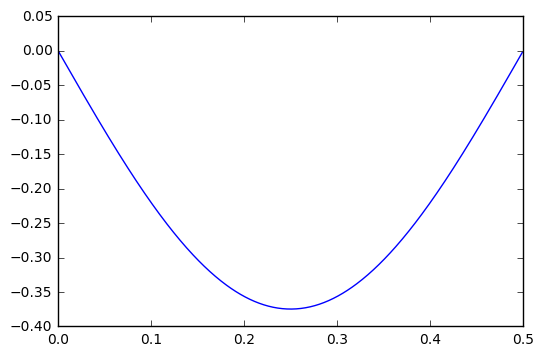

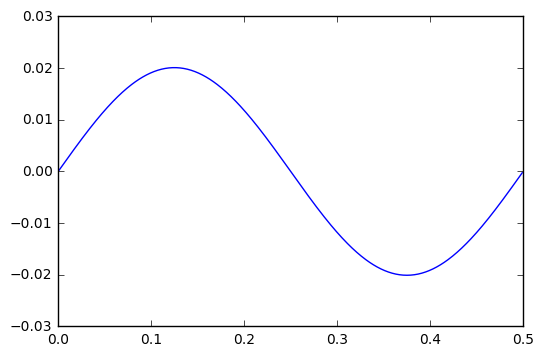

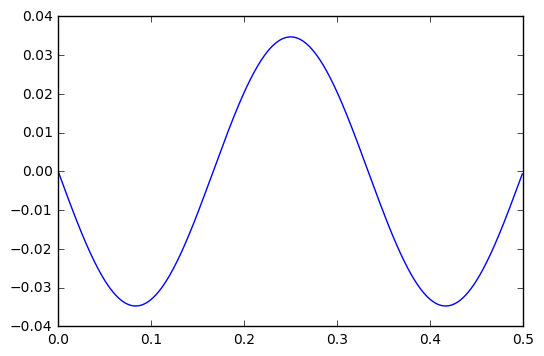

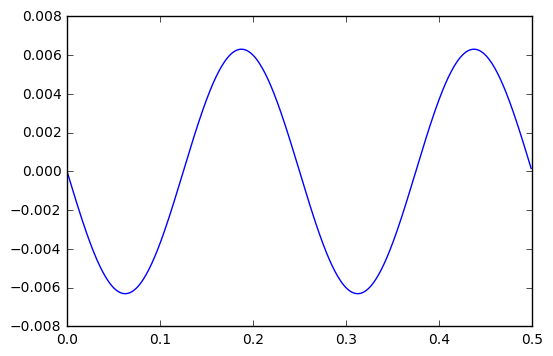

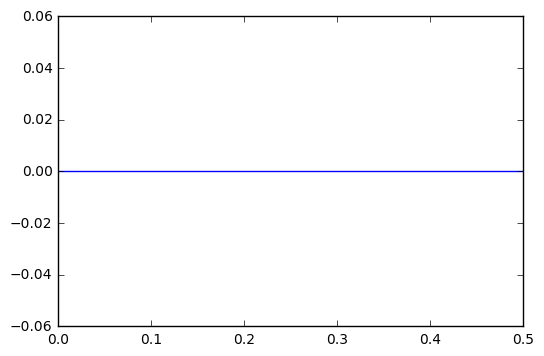

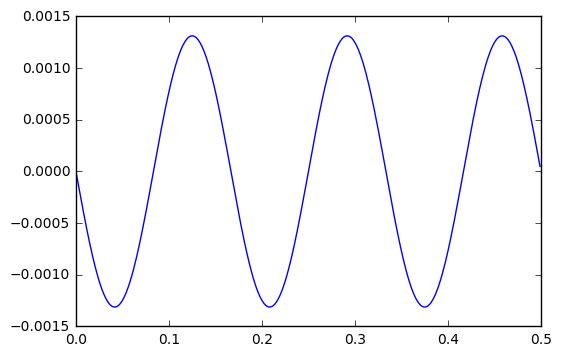

In [121]:
#toplot = 0
tt = 0.0007
for i in range(0,6):
    toplot = (An[i])*y(xx, tt, i, phase[i])
    #toplot = ret + toaddd
    plt.plot(xx, toplot)
    plt.show()
    #toprint = (An[i])*y(xx[200], tt, i, phase[i])
    #print(toprint)

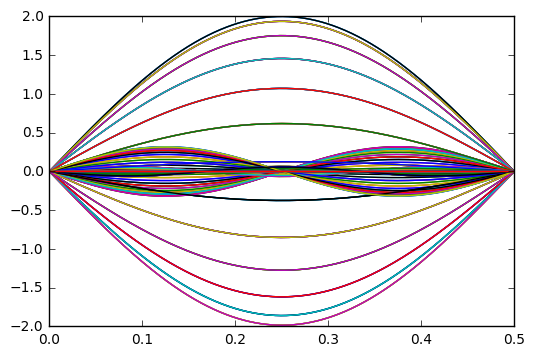

In [128]:
#kf = 4
#Xs = np.zeros(X.size, dtype=np.complex)
fig = plt.figure()
ax = plt.axes(xlim = (0,L), ylim = (-2.5, 2.5))
line, = ax.plot([], [], lw=1, color='r')
line2, = ax.plot([], [], lw=1, color='b')
line3, = ax.plot([], [], lw=1, color='k')
ax.axis("off")
lines = []
lines.append(line)
lines.append(line2)
lines.append(line3)
def init():
    line.set_data([],[])
    line2.set_data([],[])
    line3.set_data([],[])
    return lines
def animate(time):
    #Xs[kf*i] = X[kf*i]
    #Xs[-kf*i] = X[-kf*i]
    #ys = IDFT(Xs)
    #y3 = 0
    #ys = np.arange(length)
    #xx = np.arange(0, WL/2)
    line.set_data(xx,wave(xx, time*0.0001))
    #line2.set_data(xs,segment)
    #line3.set_data(xs,y3)
    return lines
    #plt.plot(ys,'r')
    #plt.plot(segment,'b')
    #plt.axis(ax)

ann = animation.FuncAnimation(fig, animate, init_func=init, frames = 60, interval = 300, blit=True)
display_animation(ann)
#ann.save('violin_fourier.mp4', writer = 'ffmpeg')

# Misc Blog Plots

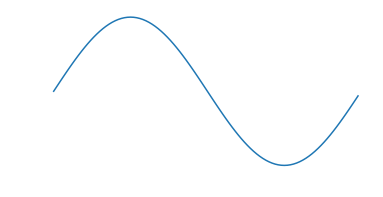

In [74]:
x = np.arange(0, 100)
fig = plt.figure(figsize=(6,3))
plt.plot(x, np.sin(x*(1*np.pi)/50))
plt.axis("off")
plt.savefig("sinewave_unit.jpg")